# **Data Science Intern - LetsGrowMore**

## **Author : Akash Jain**

## **Beginner Level Task**

## **Task 2 :**

## ***Stock Market Prediction And Forecasting Using Stacked LSTM***

## **Importing Basic Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings # supress warnings
warnings.filterwarnings('ignore')

## **Loading & Analyzing Stocks Data**

In [2]:
# Loading Tata Global Beverage’s past stock prices data 
# Making date in pandas date format and also make date column as index
data=pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv' ,infer_datetime_format=True,
                 parse_dates=['Date'], index_col=['Date'])


In [3]:
data.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
print(data.index.unique().tolist()[0])
print(data.index.unique().tolist()[-1])

2018-09-28 00:00:00
2010-07-21 00:00:00


**Given dataset has stock prices from year 2010-2019**

In [5]:
data.shape

(2035, 7)

There are 2035 Stocks Prices Records and 7 columns

In [6]:
# Checking null values
data.isnull().sum()

Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2018-09-28 to 2010-07-21
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  2035 non-null   float64
 1   High                  2035 non-null   float64
 2   Low                   2035 non-null   float64
 3   Last                  2035 non-null   float64
 4   Close                 2035 non-null   float64
 5   Total Trade Quantity  2035 non-null   int64  
 6   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 127.2 KB


## **Stock Closing Prices over the year (2010-2019)**

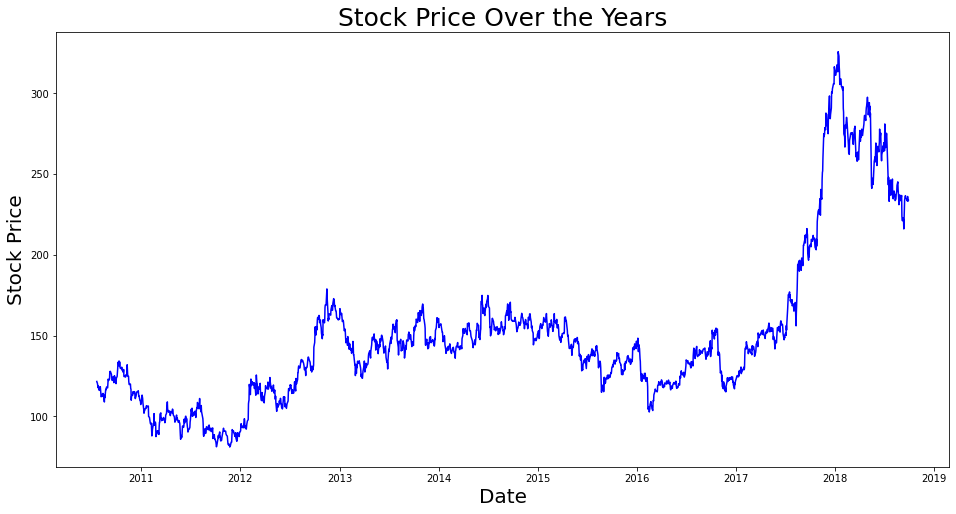

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

In [9]:
# Choosing Closing Price of the stock for training ,testing and predictions
# We do reset_index() to remove index Date values with normal index values
df=data.reset_index()['Close']

In [10]:
df

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [11]:
df1=df.copy()

## **Feature Scaling**

In [12]:
## LSTM are sensitive to the scale of the data. so we apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [13]:
df

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

## **Splitting dataset into train and test split**

In [14]:
training_size=int(len(df)*0.65) # 65% training data
test_size=len(df)-training_size # 45% test data
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:]

In [15]:
training_size,test_size


(1322, 713)

## **Data Sequencing**

In [16]:
# convert an array of values into a dataset matrix with 100 time-steps and 1 output
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1): 
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# Making training and testing data with 100 time-steps and 1 output
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape)
print(y_train.shape)


(1221, 100)
(1221,)


In [19]:
print(X_test.shape)
print(ytest.shape)


(612, 100)
(612,)


## **Reshape into 3D data**

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
print(X_train.shape)
print(X_test.shape)

(1221, 100, 1)
(612, 100, 1)


## **Builing the LSTM Model**

In [22]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
# Building the LSTM with 50 neurons and 4 hidden layers. 
# Then assigning 1 neuron in the output layer for predicting the stock price.
# Using the MSE loss function and the Adam stochastic gradient descent optimizer.
# While adding more than 1 LSTM's, we should add an argument return_sequences = True until we reached last LSTM Layer.

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # Lstm Layer with Input layer
model.add(LSTM(50,return_sequences=True)) # Lstm Layer-2
model.add(LSTM(50)) # Lstm Layer-3
model.add(Dense(1)) # output layer
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
20/20 [==============================] - 11s 78ms/step - loss: 0.0327 - val_loss: 0.0046
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 9.5469e-04
Epoch 3/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 9.0522e-04
Epoch 7/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 9.8388e-04
Epoch 8/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0012 - val

In [26]:
import tensorflow as tf

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
##Transformback to original form 
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
print(train_predict.shape)
print(test_predict.shape)

(1221, 1)
(612, 1)


In [29]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


165.41792778599122

In [30]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

115.8266659700427

# **Visualizing Stock Price Prediction for training and testing data**

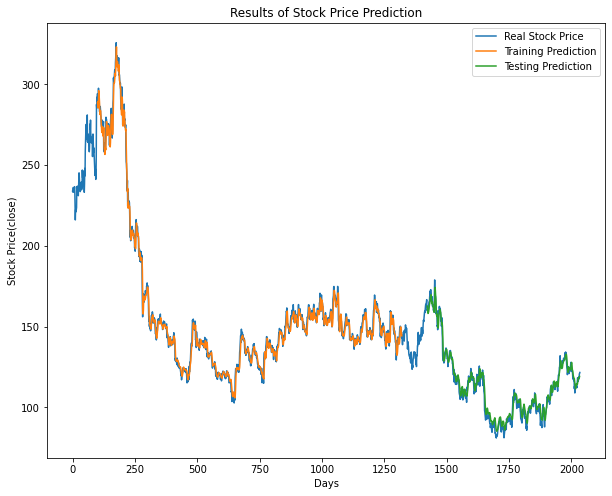

In [31]:
# Plotting 
plt.figure(figsize=(10, 8))

# shift train predictions for plotting(orange)
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting(green)
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

# plot baseline and predictions (blue)
plt.plot(scaler.inverse_transform(df), label = 'Real Stock Price')
plt.plot(trainPredictPlot, label = 'Training Prediction')
plt.plot(testPredictPlot, label = 'Testing Prediction')

plt.title('Results of Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price(close)')
plt.legend()
plt.show()

* Predicting Stock Price over test data is very close to actual data.
* LSTM model shows a good performance on this data.

## **Forecast on future 30 days**
**Collect previous 100 days data**

In [32]:
len(test_data)


713

In [33]:
x_input=test_data[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
# Contains previous 100 days data 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

## **Predict for future 30 days from previous 100 days data**



In [35]:
n_steps = len(temp_input)
for i in range(30):
    input_ = temp_input[i:]
    input_ = np.array(input_).reshape(1, n_steps, 1)
    output = model.predict(input_)[0][0]
    temp_input.append(output)

In [36]:
len(temp_input)


130

Length is 130 as it contains data of previous 100 days and 30 predicted days

In [37]:
# collect sample numbers for 100 and 30 days
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:
len(df)

2035

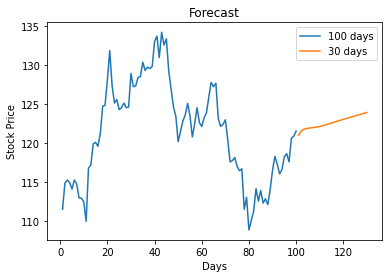

In [39]:
# Plotting Stock Price with next 30 days prediction

plt.plot(day_new, scaler.inverse_transform(np.array(df[1935:]).reshape(-1,1)), label='100 days')
plt.plot(day_pred, scaler.inverse_transform(np.array(temp_input[100:]).reshape(-1,1)), label='30 days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.legend()
plt.show()

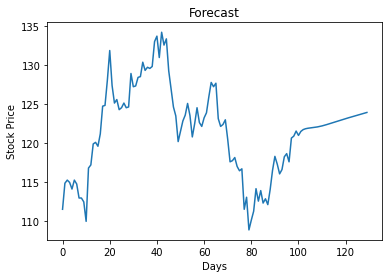

In [40]:
# Plotting the partial Forecast

plt.plot(scaler.inverse_transform(np.array(temp_input).reshape(-1,1)))
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.show()

In [41]:
len(df1)

2035

In [42]:
stock_previous = df1.to_numpy()
stock_30 = scaler.inverse_transform(np.array(temp_input[100:]).reshape(1, -1))[0]
Total_stock = np.concatenate([stock_previous, stock_30])
Total_stock.shape

(2065,)

## **Stock Price Prediction of next 30 days along with given stock price data**

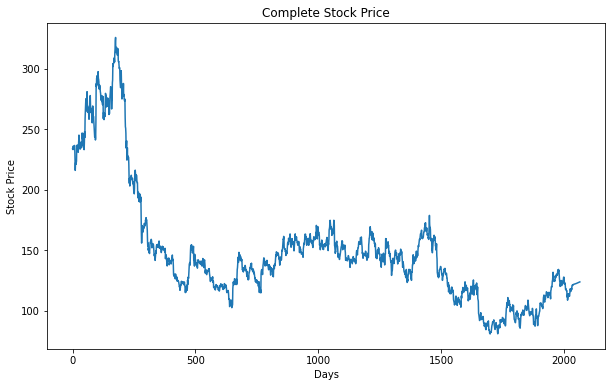

In [43]:
# plotting the complete Graph along with 30 days Forecast

plt.figure(figsize=(10,6))
plt.plot(Total_stock)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Complete Stock Price')
plt.show()

## **Conclusion:**

* There is a gradual `increase` of stock price between year `2017` to `2018`.
* Then it is going to `decrease` till `(September 2018)` 
* But there is sudden `increase` in stock closing prices in `October 2018` as predicted by our LSTM Model.
* We successfully completed the stock market prediction and forecasting using stacked LSTM model.